# **1. Introdution**
- This file was trained on google colab using data from link bellow:
https://www.kaggle.com/datasets/alessiocorrado99/animals10
- It contains about 28K medium quality animal images belonging to 10 categories: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.
- Leverage VGG16 model to classify.


# **2. Prepare data.**
- Install kaggle lib and upload file kaggle.json
(Link references: https://www.kaggle.com/general/74235)
- Download data file
- Unzip Data

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alessiocorrado99/animals10
!unzip -qq animals10.zip

100% 584M/586M [00:26<00:00, 22.6MB/s]
100% 586M/586M [00:26<00:00, 22.8MB/s]


- Make directory follow contruction.

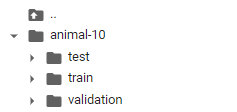



In [ ]:
import os
list_animals_names = ['dog', 'horse', 'elephant', 'buterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
list_ori_folder = os.listdir('/content/raw-img')
# Make directory structure
path = "/content/animal-10"
os.mkdir(path)

def make_directory(name_catalogy):
  sub_path = path + '/' + name_catalogy
  os.mkdir(sub_path)
  for animal_name in list_animals_names:
    os.mkdir(sub_path + '/' + animal_name)
  return

make_directory("train")
make_directory("validation")
make_directory("test")

- Make 10 sub directories in each "train", "validation", "test" and coppy image from "raw-img" folder.
- We use 70% data for train, 15% for validation and 15% for test.

In [ ]:
import shutil
import os
# ratio for train, val, and test set
ratio_train = 0.7
ratio_val = 0.15
ratio_test = ratio_train - ratio_val

ori_raw_folder = "/content/raw-img"
list_animals_names = ['dog', 'horse', 'elephant', 'buterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
list_ori_folder = sorted(os.listdir('/content/raw-img'))

for sub_ori_folder, sub_new_folder in zip(list_ori_folder, list_animals_names): # get a folder name
  sub_raw_img_name = ori_raw_folder + '/' + sub_ori_folder # address in "raw-img" folder
  list_img_in_raw_img = os.listdir(sub_raw_img_name) # List image in sub "raw_img" folder
  for i, img_org_name in enumerate(list_img_in_raw_img): 
    if i / len(list_img_in_raw_img) < ratio_train:        # Copy train
      shutil.copy(sub_raw_img_name + '/' + img_org_name,
                  path + '/train/' + sub_new_folder + '/' 
                  + sub_new_folder + '.' + str(i) + '.jpeg' )
    elif (i / len(list_img_in_raw_img) > ratio_train) and (i / len(list_img_in_raw_img) < ratio_train + ratio_val): # Copy val
      shutil.copy(sub_raw_img_name + '/' + img_org_name,
                  path + '/validation/' + sub_new_folder + '/' 
                  + sub_new_folder + '.' + str(i) + '.jpeg' )
    else: # Copy test
      shutil.copy(sub_raw_img_name + '/' + img_org_name,
                  path + '/test/' + sub_new_folder + '/' 
                  + sub_new_folder + '.' + str(i) + '.jpeg' )

- Using *image_dataset_from_directory* to read images. It will create and return a *tf.data.Dataset* object.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
img_size = (180, 180)

train_dataset = image_dataset_from_directory(
 path + "/train",
 image_size=img_size,
 batch_size=32)
validation_dataset = image_dataset_from_directory(
 path + "/validation",
 image_size=img_size,
 batch_size=32)
test_dataset = image_dataset_from_directory(
 path + "/test",
 image_size=img_size,
 batch_size=32)

Found 18331 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.
Found 3923 files belonging to 10 classes.


# **3. Build the model**.
- Model build base on VGG16 model with weight pretrain on imagetnet image data
- After VGG16 convolution layer, we use GlobalAveragePooling2d to fatten it and add 10 neral for sofmax 
- Use callbacks to save the best train model.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:

conv_base.trainable = False
"""for layer in conv_base.layers[:-2]:
  layer.trainable = False"""

data_augmentation = keras.Sequential(
    [
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.1)
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
#x = data_augmentation(inputs)
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="classify_animals_10.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [ ]:
conv_base.summary()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# **4. Train**
- Now, we start train model for 10 epochs
- The model starting overfit after 8 epochs
- The accuracy nearly reach 90% on the validation data

In [ ]:
history = model.fit(
 train_dataset,
 epochs=10,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/10
573/573 [==============================] - 85s 148ms/step - loss: 1.8033 - accuracy: 0.7601 - val_loss: 0.7696 - val_accuracy: 0.8622
Epoch 2/10
573/573 [==============================] - 85s 147ms/step - loss: 0.6165 - accuracy: 0.8835 - val_loss: 0.5858 - val_accuracy: 0.8848
Epoch 3/10
573/573 [==============================] - 85s 148ms/step - loss: 0.4539 - accuracy: 0.9038 - val_loss: 0.5721 - val_accuracy: 0.8869
Epoch 4/10
573/573 [==============================] - 85s 147ms/step - loss: 0.3583 - accuracy: 0.9155 - val_loss: 0.5558 - val_accuracy: 0.8871
Epoch 5/10
573/573 [==============================] - 85s 148ms/step - loss: 0.3138 - accuracy: 0.9205 - val_loss: 0.5458 - val_accuracy: 0.8910
Epoch 6/10
573/573 [==============================] - 85s 148ms/step - loss: 0.2769 - accuracy: 0.9289 - val_loss: 0.5515 - val_accuracy: 0.8884
Epoch 7/10
573/573 [==============================] - 85s 148ms/step - loss: 0.2552 - accuracy: 0.9313 - val_loss: 0.5243 - val_ac

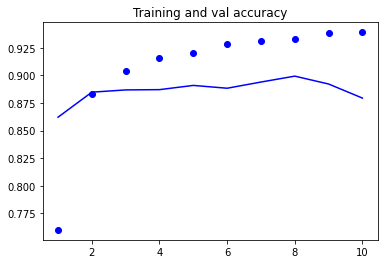

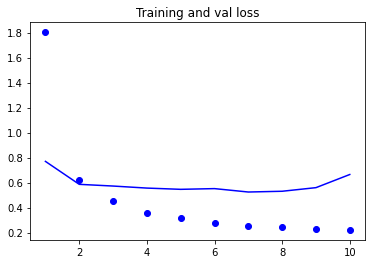

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Val_accuracy")
plt.title("Training and val accuracy")
plt.show()
plt.figure()
plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("Training and val loss")
plt.show()

# **5. Test model on validation data**

In [ ]:
# Evaluating the model on the test set
test_model = keras.models.load_model("classify_animals_10.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print("Test accurary: %.4f" %test_acc)

123/123 [==============================] - 15s 120ms/step - loss: 0.5752 - accuracy: 0.8968
Test accurary: 0.8968


# **6. Visualizing heatmaps of class activation (Grad-CAM)**
- First, We must create a model that maps the input images to the activatons of the last convolution layer.
- Then, We creast the model that maps the activation of the last convolutional to the final class predictions.
- After that, the *get_grads()* funtion will compute the gradient of top predict class with respect to the activaton of the last convolution layer

In [ ]:
#Setting up a model return the last convolutinal output
last_conv_layer_name = "block5_conv3" 
classifier_layer_names = ["global_average_pooling2d_2","dense_2"]
last_conv_layer = conv_base.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(conv_base.inputs, last_conv_layer.output)

In [ ]:
# Reapplying the classifier on top of the last convolutional output
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
  x = test_model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [ ]:
# Retrieving the gradients of the top predicted class
import tensorflow as tf

def get_grads(img_array):
  with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array) #TensorShape([1, 11, 11, 512])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)  #TensorShape([1, 10])
    top_pred_index = tf.argmax(preds[-1])  #TensorShape([10])
    top_class_channel = preds[:, top_pred_index]
  grads = tape.gradient(top_class_channel, last_conv_layer_output)
  return grads, last_conv_layer_output

- I use 9 image downloaded from google search for CAM visuallazation

In [ ]:
import matplotlib.cm as cm
import tensorflow as tf
import numpy as np 

list_online_image =[
    "https://www.eekwi.org/sites/default/files/2019-11/greysquirrel.jpg",
    "https://www.dogsnsw.org.au/media/1007/breeding-dogs.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTJCUjBD7aONJI7xzKl89nQqWww_Aub7CLxLpybCHo0JBwc-2QkEDIEON4waAOv_xrFYQE&usqp=CAU",
    "https://www.treehugger.com/thmb/SShPLoEHvhEViNtPvs82-QcCPrQ=/2121x1193/smart/filters:no_upscale()/horse.primary-e9a47e1c486c4fb7bf729e05b59cf0df.jpg",
    "https://morningchores.com/wp-content/uploads/2020/07/Sheep-Terms.jpg",
    "https://www.jesmond.com/wp-content/uploads/2020/07/spider-436947_1920-CBen_Kerckx-1024x681.jpg",
    "https://images.theconversation.com/files/472297/original/file-20220704-12-7zgqd5.jpg?ixlib=rb-1.1.0&rect=0%2C5%2C3491%2C2294&q=45&auto=format&w=496&fit=clip",
    "https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_3x2.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f7/Sparassidae_Palystes_castaneus_mature_female_9923s.jpg"  
]
heatmaps = np.zeros((9, 11, 11))
img_arrays = np.zeros((9, 180, 180, 3))

#Convert link image to array
def get_img_array(img_path, target_size):
  img_path = keras.utils.get_file(origin = img_path)
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array = keras.applications.xception.preprocess_input(array)
  return array


for k, link in enumerate(list_online_image):
  img_array = get_img_array(link, target_size=(180, 180))
  img_arrays[k, :, :, :] = img_array
  grad, last_conv_layer_output = get_grads(img_array) #get grads funtion
  
  pooled_grads = tf.reduce_mean(grad, axis=(0, 1, 2)).numpy()
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmaps[k, :, :] = heatmap

1/1 [==============================] - 0s 21ms/step
[9 4 6 6 7 8 3 9 8]


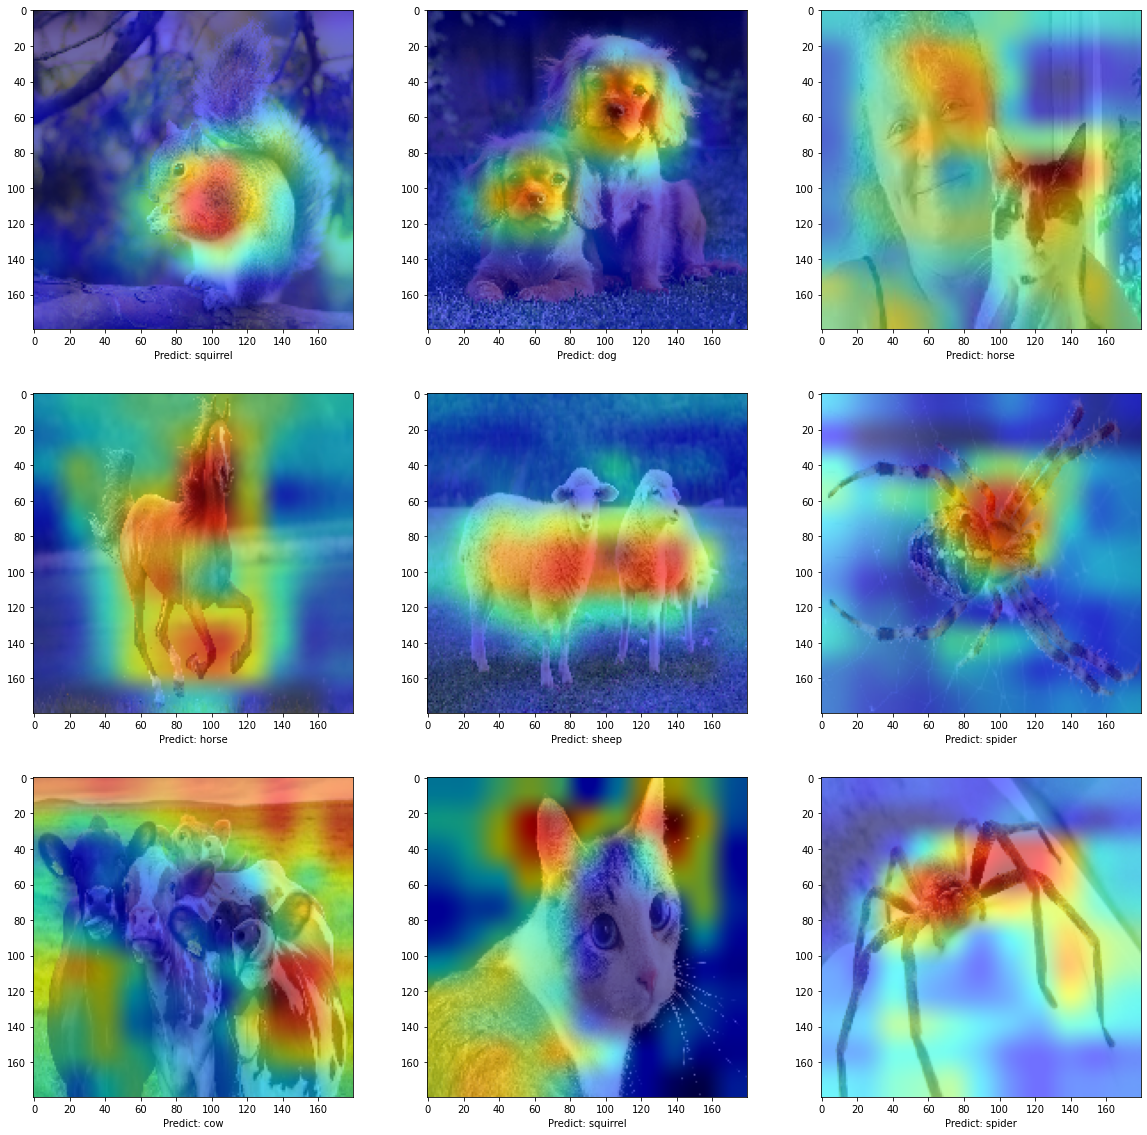

In [ ]:
# Plot the result.
import matplotlib.cm as cm
import matplotlib.pyplot as plt

catalogi = sorted(os.listdir('/content/animal-10/train'))
predict_value = test_model.predict(img_arrays)
predict_value = np.argmax(predict_value, axis = -1)
print(predict_value)

plt.figure(figsize=(20,20))
for i in range(9):

  plt.subplot(330 + 1 + i)
  img = img_arrays[i]
  heatmap = np.uint8(255 * heatmaps[i])
  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]
 
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * 0.01 + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  predict_index = predict_value[i]
  name_of_predict = catalogi[predict_index]
  plt.xlabel("Predict: %s" %name_of_predict)
  plt.imshow(superimposed_img)
plt.show()


# **7. Conclusion**
- After try with some random data, "elephant" class aren't classified well. Maybe due to the uneven distribution of the data.
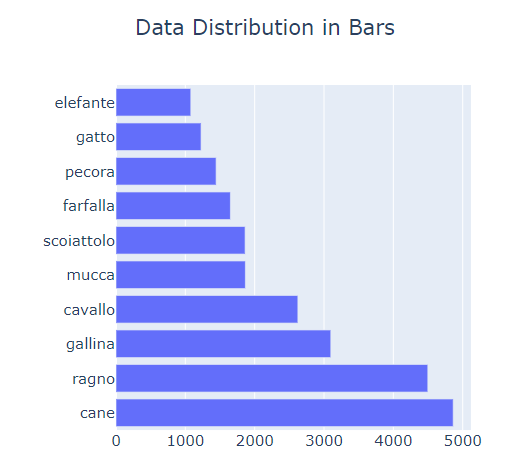 
- Image at 3rd positon with wrong classified, there is an error when there are people.
- CAM on 8th image wrong leading wrong classificaton.
